In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

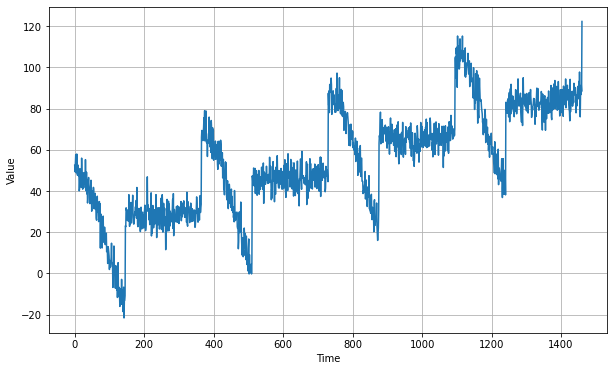

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4, 
                   np.cos(season_time * 2 * np.pi), 
                   1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_label=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
sereis = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10,6))
pblot_series(time, series)
plt.show()

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
             optimizer=optimizer,
             metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 17ms/step - loss: 195.5726 - mae: 196.0726
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 194.7820 - mae: 195.2820
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 193.5109 - mae: 194.0109
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 191.9080 - mae: 192.4080
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 190.0235 - mae: 190.5235
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 187.8582 - mae: 188.3582
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 185.3786 - mae: 185.8786
Epoch 8/100
8/8 [==============================] - 0s 10ms/step - loss: 182.5483 - mae: 183.0483
Epoch 9/100
8/8 [==============================] - 0s 10ms/step - loss: 179.3126 - mae: 179.8126
Epoch 10/100
8/8 [==============================] - 0s 10ms/step - loss: 175.6017 - mae: 176.1017
Epoch 11/100
8/8 [============

8/8 [==============================] - 0s 10ms/step - loss: 27.3829 - mae: 27.8807
Epoch 87/100
8/8 [==============================] - 0s 10ms/step - loss: 19.9041 - mae: 20.3976
Epoch 88/100
8/8 [==============================] - 0s 10ms/step - loss: 20.3712 - mae: 20.8674
Epoch 89/100
8/8 [==============================] - 0s 10ms/step - loss: 28.4273 - mae: 28.9248
Epoch 90/100
8/8 [==============================] - 0s 10ms/step - loss: 18.9119 - mae: 19.4075
Epoch 91/100
8/8 [==============================] - 0s 10ms/step - loss: 29.6508 - mae: 30.1477
Epoch 92/100
8/8 [==============================] - 0s 9ms/step - loss: 40.4210 - mae: 40.9198
Epoch 93/100
8/8 [==============================] - 0s 10ms/step - loss: 43.6692 - mae: 44.1650
Epoch 94/100
8/8 [==============================] - 0s 10ms/step - loss: 46.8259 - mae: 47.3246
Epoch 95/100
8/8 [==============================] - 0s 10ms/step - loss: 50.5486 - mae: 51.0482
Epoch 96/100
8/8 [==============================] - 0s

(1e-08, 0.0001, 0.0, 30.0)

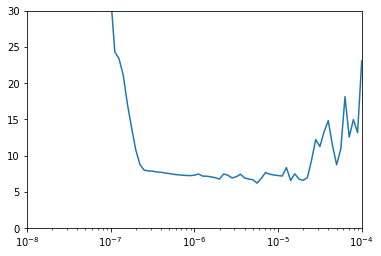

In [19]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
             optimizer=optimizer,
             metrics=["mae"])
history = model.fit(train_set, epochs=400)

Epoch 1/400
8/8 [==============================] - 0s 13ms/step - loss: 117.2725 - mae: 117.7722
Epoch 2/400
8/8 [==============================] - 0s 11ms/step - loss: 44.0110 - mae: 44.5083
Epoch 3/400
8/8 [==============================] - 0s 12ms/step - loss: 22.3317 - mae: 22.8265
Epoch 4/400
8/8 [==============================] - 0s 11ms/step - loss: 12.9401 - mae: 13.4327
Epoch 5/400
8/8 [==============================] - 0s 9ms/step - loss: 10.2014 - mae: 10.6848
Epoch 6/400
8/8 [==============================] - 0s 10ms/step - loss: 8.3282 - mae: 8.8151
Epoch 7/400
8/8 [==============================] - 0s 11ms/step - loss: 6.9704 - mae: 7.4522
Epoch 8/400
8/8 [==============================] - 0s 11ms/step - loss: 6.4044 - mae: 6.8822
Epoch 9/400
8/8 [==============================] - 0s 10ms/step - loss: 6.0183 - mae: 6.4993
Epoch 10/400
8/8 [==============================] - 0s 10ms/step - loss: 5.8204 - mae: 6.2997
Epoch 11/400
8/8 [==============================] - 0s 11m

8/8 [==============================] - 0s 11ms/step - loss: 4.8391 - mae: 5.3170
Epoch 89/400
8/8 [==============================] - 0s 10ms/step - loss: 4.6613 - mae: 5.1401
Epoch 90/400
8/8 [==============================] - 0s 10ms/step - loss: 4.6066 - mae: 5.0839
Epoch 91/400
8/8 [==============================] - 0s 11ms/step - loss: 4.6879 - mae: 5.1634
Epoch 92/400
8/8 [==============================] - 0s 10ms/step - loss: 4.6376 - mae: 5.1128
Epoch 93/400
8/8 [==============================] - 0s 10ms/step - loss: 4.7439 - mae: 5.2185
Epoch 94/400
8/8 [==============================] - 0s 10ms/step - loss: 4.8625 - mae: 5.3384
Epoch 95/400
8/8 [==============================] - 0s 10ms/step - loss: 5.0449 - mae: 5.5270
Epoch 96/400
8/8 [==============================] - 0s 10ms/step - loss: 4.6724 - mae: 5.1469
Epoch 97/400
8/8 [==============================] - 0s 10ms/step - loss: 4.6699 - mae: 5.1480
Epoch 98/400
8/8 [==============================] - 0s 10ms/step - loss: 

8/8 [==============================] - 0s 10ms/step - loss: 4.4864 - mae: 4.9614
Epoch 175/400
8/8 [==============================] - 0s 11ms/step - loss: 4.6573 - mae: 5.1318
Epoch 176/400
8/8 [==============================] - 0s 11ms/step - loss: 4.5641 - mae: 5.0354
Epoch 177/400
8/8 [==============================] - 0s 10ms/step - loss: 4.9015 - mae: 5.3846
Epoch 178/400
8/8 [==============================] - 0s 11ms/step - loss: 4.5145 - mae: 4.9850
Epoch 179/400
8/8 [==============================] - 0s 11ms/step - loss: 4.6695 - mae: 5.1418
Epoch 180/400
8/8 [==============================] - 0s 11ms/step - loss: 4.8716 - mae: 5.3489
Epoch 181/400
8/8 [==============================] - 0s 11ms/step - loss: 4.4217 - mae: 4.8981
Epoch 182/400
8/8 [==============================] - 0s 11ms/step - loss: 4.3900 - mae: 4.8678
Epoch 183/400
8/8 [==============================] - 0s 10ms/step - loss: 4.4580 - mae: 4.9301
Epoch 184/400
8/8 [==============================] - 0s 10ms/ste

8/8 [==============================] - 0s 10ms/step - loss: 4.4750 - mae: 4.9472
Epoch 261/400
8/8 [==============================] - 0s 10ms/step - loss: 4.3236 - mae: 4.7937
Epoch 262/400
8/8 [==============================] - 0s 10ms/step - loss: 4.3057 - mae: 4.7767
Epoch 263/400
8/8 [==============================] - 0s 10ms/step - loss: 4.3370 - mae: 4.8094
Epoch 264/400
8/8 [==============================] - 0s 10ms/step - loss: 4.3358 - mae: 4.8075
Epoch 265/400
8/8 [==============================] - 0s 10ms/step - loss: 4.3705 - mae: 4.8407
Epoch 266/400
8/8 [==============================] - 0s 10ms/step - loss: 4.3416 - mae: 4.8155
Epoch 267/400
8/8 [==============================] - 0s 10ms/step - loss: 4.2816 - mae: 4.7493
Epoch 268/400
8/8 [==============================] - 0s 10ms/step - loss: 4.3244 - mae: 4.8000
Epoch 269/400
8/8 [==============================] - 0s 10ms/step - loss: 4.3338 - mae: 4.8133
Epoch 270/400
8/8 [==============================] - 0s 10ms/ste

8/8 [==============================] - 0s 10ms/step - loss: 4.2461 - mae: 4.7142
Epoch 347/400
8/8 [==============================] - 0s 9ms/step - loss: 4.3061 - mae: 4.7794
Epoch 348/400
8/8 [==============================] - 0s 10ms/step - loss: 4.2793 - mae: 4.7509
Epoch 349/400
8/8 [==============================] - 0s 10ms/step - loss: 4.4198 - mae: 4.8907
Epoch 350/400
8/8 [==============================] - 0s 11ms/step - loss: 4.7918 - mae: 5.2652
Epoch 351/400
8/8 [==============================] - 0s 10ms/step - loss: 4.3428 - mae: 4.8154
Epoch 352/400
8/8 [==============================] - 0s 9ms/step - loss: 4.4721 - mae: 4.9447
Epoch 353/400
8/8 [==============================] - 0s 9ms/step - loss: 4.2650 - mae: 4.7366
Epoch 354/400
8/8 [==============================] - 0s 10ms/step - loss: 4.2982 - mae: 4.7681
Epoch 355/400
8/8 [==============================] - 0s 10ms/step - loss: 4.3335 - mae: 4.8025
Epoch 356/400
8/8 [==============================] - 0s 9ms/step - 

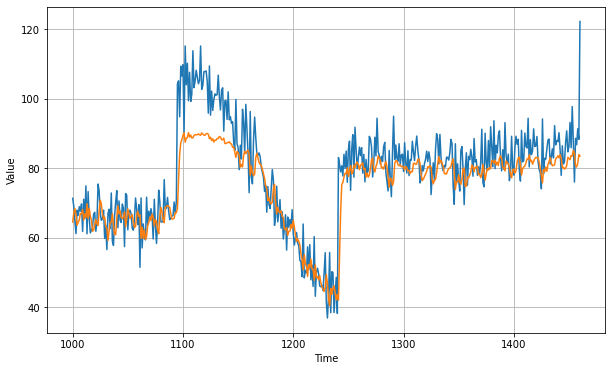

In [22]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time: time + window_size][np.newaxis]))
    
forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.0805864

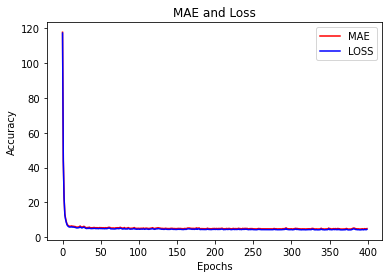

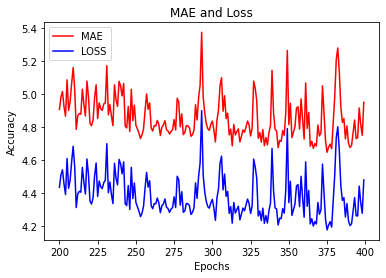

In [27]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
"""
Retrieve a list of list reults on training and test datasets for each training epoch
"""
mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss)) # Get number of epochs

"""
Plot MAE and Loss
"""
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "LOSS"])

plt.show()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

"""
Plot Zoomed MAE and Loss
"""
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "LOSS"])

plt.show()